In [1]:
import pandas as pd
import glob

In [2]:
path = "../../data/raw/btsdelay/"
file_list = glob.glob(f"{path}*.parquet")

df = pd.concat([pd.read_parquet(i) for i in file_list])

# Sampling dataframe to reduce compute time for iteration
# df = df.sample(n=100_000)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29193782 entries, 0 to 590541
Data columns (total 61 columns):
 #   Column                                   Dtype         
---  ------                                   -----         
 0   FlightDate                               datetime64[ns]
 1   Airline                                  object        
 2   Origin                                   object        
 3   Dest                                     object        
 4   Cancelled                                bool          
 5   Diverted                                 bool          
 6   CRSDepTime                               int64         
 7   DepTime                                  float64       
 8   DepDelayMinutes                          float64       
 9   DepDelay                                 float64       
 10  ArrTime                                  float64       
 11  ArrDelayMinutes                          float64       
 12  AirTime                     

Response parameters: ArrDelay, DepDelay

Propose to drop diversions. Too much complexity for our project

---
Below groups the data by airline, finds the mean delay per airline, and then creates a "network impact" column that is the total average delay (arrival + departure) multiplied by a proportion of flights per airline and the total flights.

My thinking here is that while some airlines may have greater total delay times comparatively, the impact to the overall network would be given less weight due to the lack of flights

In [4]:
print("Average delay per airline: \n")
airline_avg_arr_delay = df.groupby("Airline")['ArrDelay'].mean()
airline_avg_dep_delay = df.groupby("Airline")['DepDelay'].mean()
airline_counts = df.Airline.value_counts()
df_grouped = pd.concat([airline_avg_arr_delay, airline_avg_dep_delay, airline_counts,], axis=1) \
                .sort_values("Airline", ascending=False) \
                .rename(columns={"Airline": "Counts"})

df_grouped['network_impact'] = (df_grouped.ArrDelay + df_grouped.DepDelay) * df_grouped.Counts / sum(df_grouped.Counts)

display(df_grouped)


Average delay per airline: 



,ArrDelay,DepDelay,Counts,network_impact
Southwest Airlines Co.,2.412109,10.104476,5474339,2.347076
Delta Air Lines Inc.,-0.351041,6.683389,3294917,0.714692
SkyWest Airlines Inc.,4.366786,9.715716,3159683,1.524168
American Airlines Inc.,4.422403,10.537822,3134117,1.606065
United Air Lines Inc.,4.542438,10.193308,2354538,1.188468
Republic Airlines,1.353372,6.351047,1283704,0.338777
JetBlue Airways,10.297635,16.097994,1106079,1.000064
Envoy Air,3.108232,6.502810,1072778,0.353175
Endeavor Air Inc.,-1.130138,6.101869,998224,0.169999
Comair Inc.,4.313126,8.520930,957220,0.420809


<Axes: title={'center': 'Network impact per Airline'}>

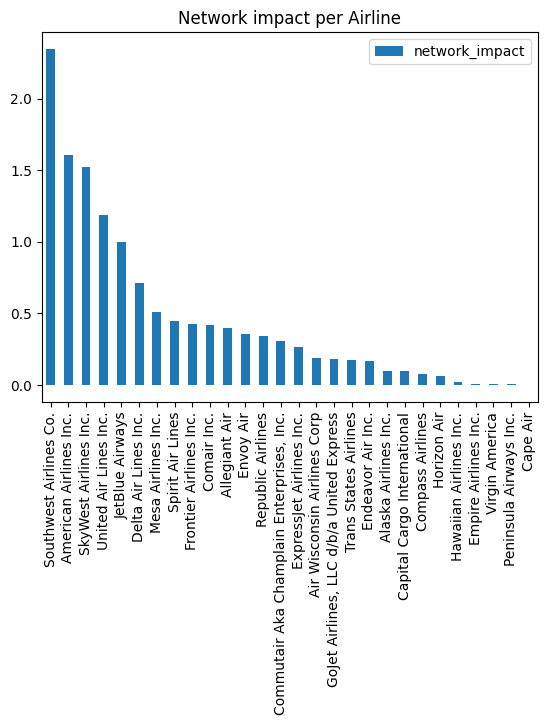

In [5]:
df_grouped.sort_values("network_impact", ascending=False) \
            .plot(
                kind="bar", 
                y="network_impact",
                title="Network impact per Airline",
            )

In [6]:
df.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2019-04-01,Envoy Air,LIT,ORD,False,False,1212,1209.0,0.0,-3.0,...,1219.0,1342.0,8.0,1405,-15.0,0.0,-1.0,1400-1459,3,0.0
1,2019-04-02,Envoy Air,LIT,ORD,False,False,1212,1200.0,0.0,-12.0,...,1210.0,1339.0,9.0,1405,-17.0,0.0,-2.0,1400-1459,3,0.0
2,2019-04-03,Envoy Air,LIT,ORD,False,False,1212,1203.0,0.0,-9.0,...,1214.0,1336.0,6.0,1405,-23.0,0.0,-2.0,1400-1459,3,0.0
3,2019-04-04,Envoy Air,LIT,ORD,False,False,1212,1435.0,143.0,143.0,...,1452.0,1615.0,6.0,1405,136.0,1.0,9.0,1400-1459,3,0.0
4,2019-04-05,Envoy Air,LIT,ORD,False,False,1212,1216.0,4.0,4.0,...,1234.0,1357.0,13.0,1405,5.0,0.0,0.0,1400-1459,3,0.0


In [7]:
print(f"% Cancelled: {len(df[df.Cancelled == True]) / len(df)*100:.2f}%")
print(f"% On time: {len(df[df.DepDelayMinutes == 0]) / len(df)*100:.2f}%")
print(f"% < 15 min dep delay: {len(df[(df.DepDelayMinutes < 15) & (df.DepDelayMinutes != 0)]) / len(df)*100:.2f}%")
print(f"% [15, 45) min dep delay: {len(df[(df.DepDelayMinutes >= 15) & (df.DepDelayMinutes < 45)]) / len(df)*100:.2f}%")
print(f"% > 45 min dep delay: {len(df[df.DepDelayMinutes >= 45]) / len(df)*100:.2f}%")

% Cancelled: 2.66%
% On time: 65.93%
% < 15 min dep delay: 14.64%
% [15, 45) min dep delay: 9.03%
% > 45 min dep delay: 7.80%


In [8]:
delay_15 = df[(df.DepDelayMinutes < 15) & (df.DepDelayMinutes != 0)].copy()
sel_cols = ["Airline", "ArrDelay", "ArrDelayMinutes", "DepDelay", "DepDelayMinutes", "eff_dep_delay"]
delay_15["eff_dep_delay"] = delay_15.DepDelay - delay_15.ArrDelay

df[(df.DepDelay != df.DepDelayMinutes) & (df.DepDelay > 0)]

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings


Above shows that there were no instances of differing departure delay and delay minutes. I was testing to see if the arrival delay was responsible for the late departure

**I Had this backwards, it goes dep -> arr, not arr -> dep...**

In [9]:
good_makeup_df = df[(df.ArrDelay < df.DepDelay)][["Airline", "ArrTime", "DepTime", "ArrDelay", "DepDelay"]]
bad_makeup_df = df[(df.ArrDelay > df.DepDelay)][["Airline", "ArrTime", "DepTime", "ArrDelay", "DepDelay"]]

good_makeup_df['time_gained'] = abs((good_makeup_df.ArrDelay - good_makeup_df.DepDelay))
bad_makeup_df['time_lost'] = abs((bad_makeup_df.ArrDelay - bad_makeup_df.DepDelay)) 

avg_good_makeup_df = good_makeup_df.groupby("Airline").agg({
    "ArrDelay": "mean", 
    "DepDelay": "mean", 
    "time_gained": "mean", 
    "Airline": lambda x: x.count() / len(good_makeup_df),
}).rename(columns={"Airline": "frac_total_flights", "time_gained": "avg_time_gained"})
avg_good_makeup_df["network_impact"] = avg_good_makeup_df.avg_time_gained * avg_good_makeup_df.frac_total_flights


avg_bad_makeup_df = bad_makeup_df.groupby("Airline").agg({
    "ArrDelay": "mean", 
    "DepDelay": "mean", 
    "time_lost": "mean", 
    "Airline": lambda x: x.count() / len(bad_makeup_df),
}).rename(columns={"Airline": "frac_total_flights", "time_lost": "avg_time_gained"})
avg_bad_makeup_df["network_impact"] = avg_bad_makeup_df.avg_time_gained * avg_bad_makeup_df.frac_total_flights * -1


In [10]:
print("Good")
display(avg_good_makeup_df.sort_values("network_impact", ascending=False).head(5))

print("Bad")
display(avg_bad_makeup_df.sort_values("network_impact", ascending=True).head(5))

Good


,ArrDelay,DepDelay,avg_time_gained,frac_total_flights,network_impact
Airline,,,,,
Southwest Airlines Co.,-1.669259,9.497998,11.167257,0.210088,2.346105
Delta Air Lines Inc.,-5.877098,6.153484,12.030582,0.120133,1.445273
American Airlines Inc.,-2.477683,9.868901,12.346584,0.106900,1.319854
SkyWest Airlines Inc.,-2.333158,9.138179,11.471336,0.106099,1.217096
United Air Lines Inc.,-2.673282,9.544435,12.217717,0.080145,0.979185


Bad


,ArrDelay,DepDelay,avg_time_gained,frac_total_flights,network_impact
Airline,,,,,
American Airlines Inc.,24.254591,12.420171,11.834420,0.107909,-1.277046
SkyWest Airlines Inc.,22.283344,11.295623,10.987720,0.115744,-1.271763
Southwest Airlines Co.,22.377048,13.081750,9.295298,0.120408,-1.119227
United Air Lines Inc.,24.455660,12.040078,12.415582,0.084892,-1.053985
Delta Air Lines Inc.,19.030014,8.524784,10.505231,0.098252,-1.032162


In [11]:
total_makeup_df = avg_good_makeup_df.join(avg_bad_makeup_df, on="Airline", lsuffix="_good", rsuffix="_bad")
total_makeup_df.dropna(inplace=True)
total_makeup_df['overall_network_impact'] = total_makeup_df.network_impact_good + total_makeup_df.network_impact_bad

total_makeup_df.overall_network_impact.sort_values(ascending=False)

Airline
Southwest Airlines Co.                       1.226879
Delta Air Lines Inc.                         0.413111
Endeavor Air Inc.                            0.128828
American Airlines Inc.                       0.042808
Cape Air                                    -0.000472
Peninsula Airways Inc.                      -0.001177
Virgin America                              -0.003058
Empire Airlines Inc.                        -0.004570
Compass Airlines                            -0.010369
GoJet Airlines, LLC d/b/a United Express    -0.013938
Spirit Air Lines                            -0.021974
Air Wisconsin Airlines Corp                 -0.036438
Frontier Airlines Inc.                      -0.039835
Trans States Airlines                       -0.044396
Capital Cargo International                 -0.045657
Hawaiian Airlines Inc.                      -0.049724
SkyWest Airlines Inc.                       -0.054668
Mesa Airlines Inc.                          -0.056994
Horizon Air         

Expanded calculation of simplified network impact. This only takes into consideration the proportion of flights in like categories 

---
Focus on Airports now instead of individual flights

In [12]:
df.groupby("Origin").Origin.count().sort_values(ascending=False)

Origin
ORD    1375187
ATL    1371796
DEN    1170585
DFW    1104266
CLT     907841
        ...   
CDB        262
BFM        205
ILG        165
ROP        151
YNG          2
Name: Origin, Length: 388, dtype: int64

In [16]:

port_dest_df = df.groupby(["Origin", "Dest"]).agg({
    "DepDelay": "mean",
    "ArrDelay": "mean",
    "Dest": "count"
}).dropna().sort_values("ArrDelay", ascending=False) \
  .rename(columns={
    "Dest": "flight_count",
    "DepDelay": "avg_dep_delay",
    "ArrDelay": "avg_arr_delay",
})
port_dest_df

,,avg_dep_delay,avg_arr_delay,flight_count
Origin,Dest,,,
RDM,MFR,814.0,1347.0,2
MDT,HPN,759.0,798.0,1
VPS,SRQ,720.0,744.0,1
DAB,DTW,248.0,227.0,1
ICT,DAY,181.0,210.0,1
...,...,...,...,...
BHM,CAE,-7.0,-54.0,1
CAE,BHM,-10.0,-55.0,1
DEN,SBN,-17.0,-57.0,1


In [15]:
port_dest_df.sort_values("flight_count", ascending=False).head(10)

avg_dep_delay  avg_arr_delay  flight_count
Origin Dest                                            
SFO    LAX        7.918641       1.102596         56204
LAX    SFO        9.308275       2.850463         56194
       LAS        7.811482       2.733496         44668
LAS    LAX        8.804042       2.988827         44575
ORD    LGA       15.505013      10.702464         44364
LGA    ORD       14.220532       6.399252         44338
HNL    OGG        0.552596      -0.168819         40725
OGG    HNL        0.779352       0.070391         40722
LAX    JFK       10.453907      -0.147342         40381
JFK    LAX        8.271107      -3.033413         40315

In [21]:
port_dest_df['network_impact'] = (port_dest_df.avg_arr_delay + port_dest_df.avg_dep_delay) * port_dest_df.flight_count / sum(port_dest_df.flight_count)
port_dest_df.sort_values("network_impact", ascending=False).head(10)

avg_dep_delay  avg_arr_delay  flight_count  network_impact
Origin Dest                                                            
ORD    LGA       15.505013      10.702464         44364        0.039826
MCO    EWR       20.861615      17.250739         28318        0.036969
LGA    ORD       14.220532       6.399252         44338        0.031316
EWR    MCO       17.102543      11.687791         28328        0.027937
FLL    EWR       19.590985      15.237009         22277        0.026576
LAX    SFO        9.308275       2.850463         56194        0.023404
ATL    EWR       16.993806      11.063902         23911        0.022981
EWR    FLL       17.754029      11.450405         22277        0.022285
       BOS       18.328279      13.316285         18780        0.020357
IAH    DFW       14.691591      11.735064         22475        0.020345

In [23]:
df.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2019-04-01,Envoy Air,LIT,ORD,False,False,1212,1209.0,0.0,-3.0,...,1219.0,1342.0,8.0,1405,-15.0,0.0,-1.0,1400-1459,3,0.0
1,2019-04-02,Envoy Air,LIT,ORD,False,False,1212,1200.0,0.0,-12.0,...,1210.0,1339.0,9.0,1405,-17.0,0.0,-2.0,1400-1459,3,0.0
2,2019-04-03,Envoy Air,LIT,ORD,False,False,1212,1203.0,0.0,-9.0,...,1214.0,1336.0,6.0,1405,-23.0,0.0,-2.0,1400-1459,3,0.0
3,2019-04-04,Envoy Air,LIT,ORD,False,False,1212,1435.0,143.0,143.0,...,1452.0,1615.0,6.0,1405,136.0,1.0,9.0,1400-1459,3,0.0
4,2019-04-05,Envoy Air,LIT,ORD,False,False,1212,1216.0,4.0,4.0,...,1234.0,1357.0,13.0,1405,5.0,0.0,0.0,1400-1459,3,0.0


In [28]:
df.groupby("Month")[['DepDelay', 'ArrDelay']].mean()

,DepDelay,ArrDelay
Month,,
1,8.148354,1.386309
2,9.944549,4.021496
3,7.017095,0.643520
4,8.375620,2.257858
5,9.818360,4.071035
6,14.093493,9.216827
7,13.035756,8.017081
8,11.392843,6.670743
9,5.719523,-0.010336
